### **📖 1. CDC là gì?**

**Change Data Capture (CDC)** = Bắt mọi thay đổi (INSERT, UPDATE, DELETE) trong database và stream chúng ra ngoài REAL-TIME.

In [ ]:
Database thay đổi → CDC bắt được → Đẩy sang Kafka → Consumer xử lý

**Tại sao cần CDC?**

  - ❌ Cách cũ: Chạy batch job mỗi 1 giờ để sync data → Lag 1 giờ

  - ✅ CDC: Thay đổi nào cũng được đẩy ngay lập tức → Near real-time

### **🔬 2. Debezium CDC hoạt động như thế nào?**

Debezium **KHÔNG query database**, mà **đọc transaction log** của database!



**DEBEZIUM CDC FLOW**                        

**1. Application thực hiện thay đổi**:

   - INSERT INTO users (id, name) VALUES (1, 'John');

**2. PostgreSQL ghi vào WAL (Write-Ahead Log):[WAL Entry]**

   - LSN: 0/16B7408
   - Transaction ID: 12345
   - Table: public.users
   - Operation: INSERT
   - Data: {id: 1, name: 'John'}

**3. Debezium Connector đọc WAL:**

   - Connect tới replication slot
   - Stream WAL changes
   - Parse binary log format

**4. Debezium convert sang JSON:**

   - {
     "before": null,\
     "after": {"id": 1, "name": "John"},\
     "op": "c" (create/insert)\
   }

**5. Đẩy lên Kafka Topic:**

   - Topic: postgres.public.users\
     Message: {...change event...}

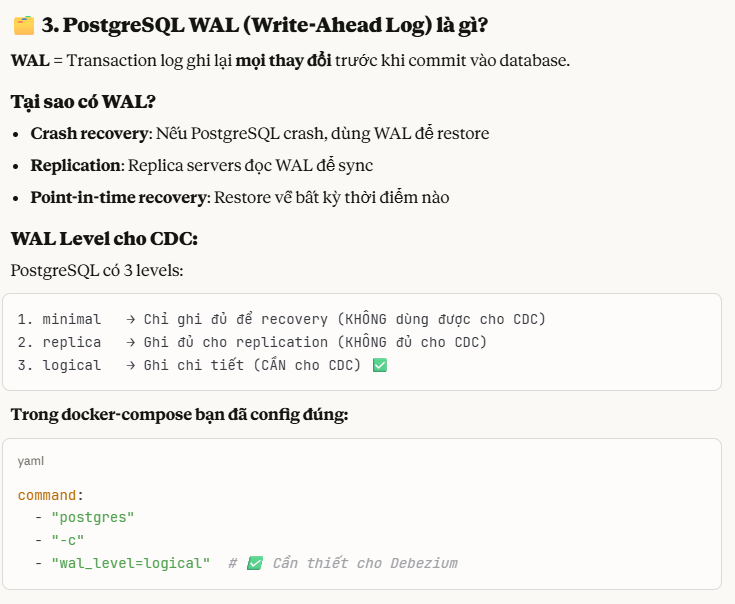

**📦 4. Debezium đẩy gì lên Kafka?**


**A. Message Structure (Change Event)**\
Mỗi thay đổi trong DB → 1 message trong Kafka với cấu trúc:

In [ ]:
{
  "schema": { /* Schema của record */ },
  "payload": {
    "before": { /* Dữ liệu TRƯỚC khi thay đổi */ },
    "after": { /* Dữ liệu SAU khi thay đổi */ },
    "source": { /* Metadata về nguồn */ },
    "op": "c|u|d|r", /* Operation type */
    "ts_ms": 1699200000000 /* Timestamp */
  }
}

**B. Các loại Operations:**\
🟢 INSERT (op: "c" - create)

In [ ]:
-- Application thực hiện:
INSERT INTO users (id, name, email, created_at)
VALUES (1, 'John Doe', 'john@example.com', NOW());

**Debezium đẩy lên Kafka:**


In [ ]:
{
  "payload": {
    "before": null,  // ← Không có data trước đó
    "after": {       // ← Data mới INSERT
      "id": 1,
      "name": "John Doe",
      "email": "john@example.com",
      "created_at": "2024-10-08T10:30:00Z"
    },
    "source": {
      "version": "2.5.0.Final",
      "connector": "postgresql",
      "name": "postgres",
      "ts_ms": 1699200000000,
      "db": "myapp_db",
      "schema": "public",
      "table": "users",
      "txId": 12345,
      "lsn": 23456789  // ← WAL position
    },
    "op": "c",  // ← Create (INSERT)
    "ts_ms": 1699200000500
  }
}

**🟡 UPDATE (op: "u" - update)**


-- Application thực hiện:\
UPDATE users \
SET name = 'John Smith', email = 'john.smith@example.com'\
WHERE id = 1;

**Debezium đẩy lên Kafka:**


In [ ]:
{
  "payload": {
    "before": {      // ← Data TRƯỚC khi UPDATE
      "id": 1,
      "name": "John Doe",
      "email": "john@example.com",
      "created_at": "2024-10-08T10:30:00Z"
    },
    "after": {       // ← Data SAU khi UPDATE
      "id": 1,
      "name": "John Smith",
      "email": "john.smith@example.com",
      "created_at": "2024-10-08T10:30:00Z"
    },
    "source": { /* ... */ },
    "op": "u",  // ← Update
    "ts_ms": 1699200060000
  }
}

**🔴 DELETE (op: "d" - delete)**


In [ ]:
-- Application thực hiện:
DELETE FROM users WHERE id = 1;

**Debezium đẩy lên Kafka:**


In [ ]:
{
  "payload": {
    "before": {      // ← Data bị XÓA
      "id": 1,
      "name": "John Smith",
      "email": "john.smith@example.com",
      "created_at": "2024-10-08T10:30:00Z"
    },
    "after": null,   // ← Không còn data
    "source": { /* ... */ },
    "op": "d",  // ← Delete
    "ts_ms": 1699200120000
  }
}

**⚪ READ/SNAPSHOT (op: "r" - read)**


Khi Debezium **lần đầu connect**, nó snapshot toàn bộ data hiện có:




In [ ]:
{
  "payload": {
    "before": null,
    "after": {
      "id": 1,
      "name": "Existing User",
      "email": "existing@example.com"
    },
    "source": {
      "snapshot": "true"  // ← Đánh dấu là snapshot
    },
    "op": "r",  // ← Read (snapshot)
    "ts_ms": 1699199000000
  }
}

**🗺️ 5. Kafka Topic Structure**\
Debezium tạo topics theo cấu trúc:


In [ ]:
<server.name>.<database>.<schema>.<table>

Ví dụ với config của bạn:
├─ postgres.myapp_db.public.users       ← Mỗi bảng 1 topic
├─ postgres.myapp_db.public.orders
├─ postgres.myapp_db.public.products
└─ ... (mỗi table = 1 topic)

**Ví dụ cụ thể**:
Giả sử bạn có 3 tables: users, orders, products

Kafka Topics được tạo:
1. postgres.myapp_db.public.users
   - Mọi thay đổi của bảng users
   
2. postgres.myapp_db.public.orders
   - Mọi thay đổi của bảng orders
   
3. postgres.myapp_db.public.products
   - Mọi thay đổi của bảng products

4. debezium_configs (internal)
   - Lưu config của connectors
   
5. debezium_offsets (internal)
   - Lưu vị trí đã đọc đến đâu trong WAL
   
6. debezium_statuses (internal)
   - Lưu trạng thái của connectors

### **🔍 6. Partition: Hash(primary_key) → partition number**


**Kafka Partition là gì?**


In [ ]:
1 Kafka Topic = Nhiều Partitions (shards)

Topic: postgres.myapp_db.public.users
├─ Partition 0: [msg1, msg2, msg5, ...]
├─ Partition 1: [msg3, msg6, msg8, ...]
└─ Partition 2: [msg4, msg7, msg9, ...]

**Tại sao cần partition?**

- **Parallel processing**: Nhiều consumer cùng xử lý
- **Scalability**: Thêm partition = tăng throughput
- **Ordering**: Trong 1 partition, messages có thứ tự

**Debezium chọn partition như thế nào?**


In [ ]:
Debezium dùng PRIMARY KEY để hash:

Hash(primary_key) % num_partitions = partition_number

Ví dụ topic có 3 partitions:
├─ User id=1 → Hash(1) = 12345 → 12345 % 3 = 0 → Partition 0
├─ User id=2 → Hash(2) = 67890 → 67890 % 3 = 0 → Partition 0
├─ User id=3 → Hash(3) = 11111 → 11111 % 3 = 2 → Partition 2
└─ User id=4 → Hash(4) = 22222 → 22222 % 3 = 1 → Partition 1

**Tại sao hash theo primary key?**


In [ ]:
┌─────────────────────────────────────────────────────┐
│   ĐẢM BẢO ORDERING CHO CÙNG 1 ROW                   │
└─────────────────────────────────────────────────────┘

Ví dụ: User id=1 có 3 operations:

Time 1: INSERT user id=1, name="Alice"
Time 2: UPDATE user id=1, name="Alice Smith"
Time 3: DELETE user id=1

Cả 3 operations đều có id=1
→ Hash(1) luôn cho ra cùng 1 partition
→ Partition 0: [INSERT, UPDATE, DELETE] (đúng thứ tự)

Nếu không hash theo PK:
❌ INSERT → Partition 0
❌ UPDATE → Partition 2
❌ DELETE → Partition 1
→ Consumer xử lý sai thứ tự → DATA CORRUPTION!

### **🎬 7. Luồng hoạt động FULL FLOW**


In [ ]:
┌──────────────────────────────────────────────────────────────┐
│              FULL CDC FLOW VỚI DEBEZIUM                      │
└──────────────────────────────────────────────────────────────┘

[1] Application INSERT user
    ↓
[2] PostgreSQL ghi vào WAL
    Location: /var/lib/postgresql/data/pg_wal/000000010000000000000001
    Entry: BEGIN; INSERT INTO users...; COMMIT;
    ↓
[3] Debezium connector đọc từ replication slot
    Connection: JDBC + Logical Replication Protocol
    ↓
[4] Debezium parse WAL entry
    Binary → Logical format → JSON
    ↓
[5] Debezium tạo Change Event
    {
      "before": null,
      "after": {"id": 1, ...},
      "op": "c"
    }
    ↓
[6] Debezium Producer đẩy lên Kafka
    Topic: postgres.myapp_db.public.users
    Partition: Hash(primary_key) → partition number
    ↓
[7] Kafka lưu message
    Broker: kafka:9092
    Partition: 0, Offset: 12345
    ↓
[8] Consumer đọc từ Kafka
    - Spark Streaming
    - Flink
    - Custom consumer
    ↓
[9] Process & Sink
    - Transform data
    - Write to Data Lake (Iceberg)
    - Write to Data Warehouse
    - Update cache
    - Trigger alerts

**8. Một số kiến thưc bổ sung**

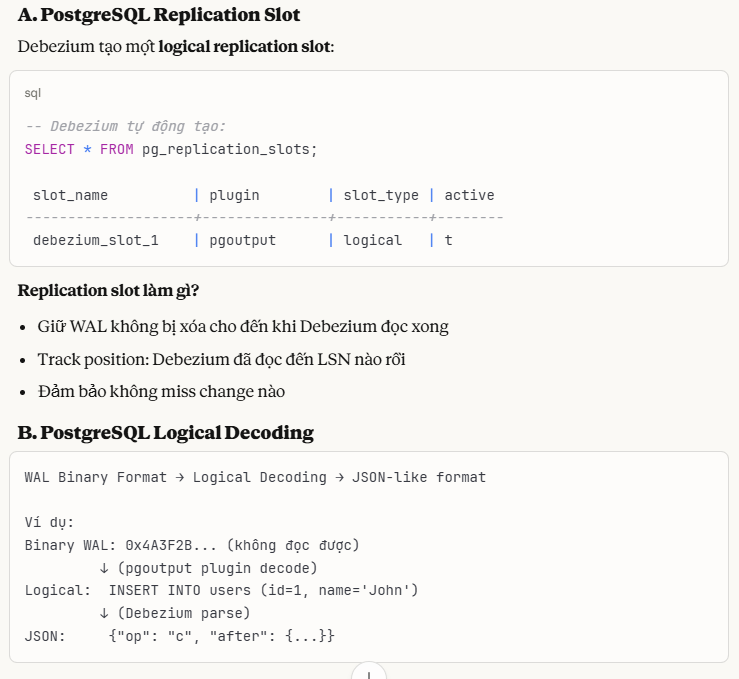

**1. Replication Slot là gì?**\

Là một "bookmark" trên PostgreSQL WAL (Write-Ahead Log)
Đánh dấu vị trí mà consumer (Debezium) đã đọc đến đâu
Đảm bảo PostgreSQL không xóa WAL logs mà consumer chưa đọc

Xem replication slots:


In [ ]:
SELECT * FROM pg_replication_slots;

Kết quả:

In [ ]:
slot_name        | plugin   | slot_type | active | restart_lsn
-----------------+----------+-----------+--------+-------------
debezium_slot    | pgoutput | logical   | t      | 0/1234567

**2. Publication là gì?**

Định nghĩa **NHỮNG GÌ** sẽ được replicate (bảng nào, loại thay đổi nào)
Giống như "danh sách phát hành" - quyết định data nào được publish ra ngoài
Chỉ dùng với plugin pgoutput (không cần với wal2json hay decoderbufs)

In [ ]:
┌─────────────────────────────────────────────────┐
│          PostgreSQL Database                    │
│                                                 │
│  ┌──────────────────────────────────────┐       │
│  │  Publication (debezium_publication)   │      │
│  │  - Định nghĩa: tables + operations    │      │
│  │  - VD: users, orders (INSERT/UPDATE)  │      │
│  └──────────────────────────────────────┘       │
│                     │                           │
│                     ▼                           │
│  ┌──────────────────────────────────────┐       │
│  │      WAL (Write-Ahead Log)           │       │
│  │  Changes: INSERT/UPDATE/DELETE       │       │
│  └──────────────────────────────────────┘       │
│                     │                           │
│                     ▼                           │
│  ┌──────────────────────────────────────┐       │
│  │  Replication Slot (debezium_slot)    │       │
│  │  - Bookmark: vị trí đã đọc           │       │
│  │  - Giữ WAL logs không bị xóa         │       │
│  └──────────────────────────────────────┘       │
│                     │                           │
└─────────────────────┼───────────────────────────┘
                      │
                      ▼
           ┌──────────────────┐
           │    Debezium      │
           │   Connector      │
           └──────────────────┘
                      │
                      ▼
           ┌──────────────────┐
           │      Kafka       │
           └──────────────────┘